<a href="https://colab.research.google.com/github/Suryaprabha19/Phishing-Detection/blob/main/Phishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [ ]:
!pip install tld==0.13

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 4.2 MB/s eta 0:00:00


In [ ]:
!pip install googlesearch-python

In [ ]:
## Results

The model achieves high accuracy in detecting phishing websites.

## Dependencies

The project requires the following libraries:

- pandas
- numpy
- seaborn
- matplotlib
- re
- urllib
- tld
- googlesearch
- scikit-learn
- imblearn
- catboost
- xgboost

You can install them using pip:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from urllib.parse import urlparse
from tld import get_tld
from googlesearch import search
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve

In [ ]:
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
df=pd.read_csv("/content/corrected_data_urls.csv")

In [ ]:
df.head()

,url,status
0,0000111servicehelpdesk.godaddysites.com,0
1,000011accesswebform.godaddysites.com,0
2,00003.online,1
3,0009servicedeskowa.godaddysites.com,0
4,000n38p.wcomhost.com,0


In [ ]:
df.shape

(822010, 2)

In [ ]:
df.columns

Index(['url', 'status'], dtype='object')

In [ ]:
# Define feature extraction functions
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'  # IPv4
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # IPv6
    return 1 if match else 0

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    return 1 if match else 0

def google_index(url):
    try:
        site = search(url, num_results=1)
        return 1 if site else 0
    except:
        return 0

def count_dot(url):
    return url.count('.')

def count_www(url):
    return url.count('www')

def count_atrate(url):
    return url.count('@')

def no_of_dir(url):
    return urlparse(url).path.count('/')

def no_of_embed(url):
    return urlparse(url).path.count('//')

def shortening_service(url):
    match = re.search(
        'bit\\.ly|goo\\.gl|shorte\\.st|x\\.co|ow\\.ly|t\\.co|tinyurl|is\\.gd|tr\\.im|cli\\.gs|tweez\\.me',
        url)
    return 1 if match else 0

def count_https(url):
    return url.count('https')

def count_http(url):
    return url.count('http')

def count_per(url):
    return url.count('%')

def count_ques(url):
    return url.count('?')

def count_hyphen(url):
    return url.count('-')

def count_equal(url):
    return url.count('=')

def url_length(url):
    return len(url)

def hostname_length(url):
    return len(urlparse(url).netloc)

def suspicious_words(url):
    match = re.search(
        'paypal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
        url)
    return 1 if match else 0

def digit_count(url):
    return sum(c.isdigit() for c in url)

def letter_count(url):
    return sum(c.isalpha() for c in url)

def fd_length(url):
    url_path = urlparse(url).path
    return len(url_path.split('/')[1]) if len(url_path.split('/')) > 1 else 0

def tld_length(url):
    try:
        tld = get_tld(url, fail_silently=True)
        return len(tld)
    except:
        return -1

In [ ]:
# Feature extraction wrapper
def process_dataframe(dataframe):
    dataframe['use_of_ip'] = dataframe['url'].apply(having_ip_address)
    dataframe['abnormal_url'] = dataframe['url'].apply(abnormal_url)
    dataframe['google_index'] = dataframe['url'].apply(google_index)
    dataframe['count.'] = dataframe['url'].apply(count_dot)
    dataframe['count-www'] = dataframe['url'].apply(count_www)
    dataframe['count@'] = dataframe['url'].apply(count_atrate)
    dataframe['count_dir'] = dataframe['url'].apply(no_of_dir)
    dataframe['count_embed_domian'] = dataframe['url'].apply(no_of_embed)
    dataframe['short_url'] = dataframe['url'].apply(shortening_service)
    dataframe['count-https'] = dataframe['url'].apply(count_https)
    dataframe['count-http'] = dataframe['url'].apply(count_http)
    dataframe['count%'] = dataframe['url'].apply(count_per)
    dataframe['count?'] = dataframe['url'].apply(count_ques)
    dataframe['count-'] = dataframe['url'].apply(count_hyphen)
    dataframe['count='] = dataframe['url'].apply(count_equal)
    dataframe['url_length'] = dataframe['url'].apply(url_length)
    dataframe['hostname_length'] = dataframe['url'].apply(hostname_length)
    dataframe['sus_url'] = dataframe['url'].apply(suspicious_words)
    dataframe['count-digits'] = dataframe['url'].apply(digit_count)
    dataframe['count-letters'] = dataframe['url'].apply(letter_count)
    dataframe['fd_length'] = dataframe['url'].apply(fd_length)
    dataframe['tld_length'] = dataframe['url'].apply(lambda x: tld_length(x))
    return dataframe

In [ ]:
# Process the dataset
df = process_dataframe(df)

In [ ]:
df.columns

Index(['url', 'status', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [ ]:
X = df[['use_of_ip', 'abnormal_url', 'google_index', 'count.', 'count-www', 'count@',
        'count_dir', 'count_embed_domian', 'short_url', 'count-https', 'count-http',
        'count%', 'count?', 'count-', 'count=', 'url_length', 'hostname_length',
        'sus_url', 'count-digits', 'count-letters', 'fd_length', 'tld_length']]

y = df['status']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print("\ny_test value counts:")
print(y_test.value_counts())


y_test value counts:
status
1    97966
0    66436
Name: count, dtype: int64


In [ ]:
print("Class distribution before SMOTE:", y_train.value_counts())

Class distribution before SMOTE: status
1    391865
0    265743
Name: count, dtype: int64


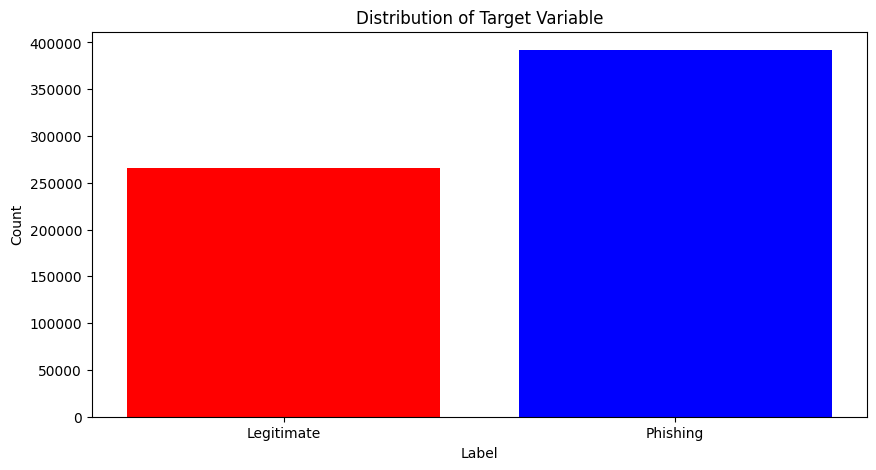

In [ ]:
y_counts_original = y_train.value_counts()
plt.figure(figsize=(10, 5))
plt.bar(y_counts_original.index, y_counts_original.values, color=['blue', 'red'])
plt.title('Distribution of Target Variable')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(y_counts_original.index, ['Phishing', 'Legitimate'])
plt.show()

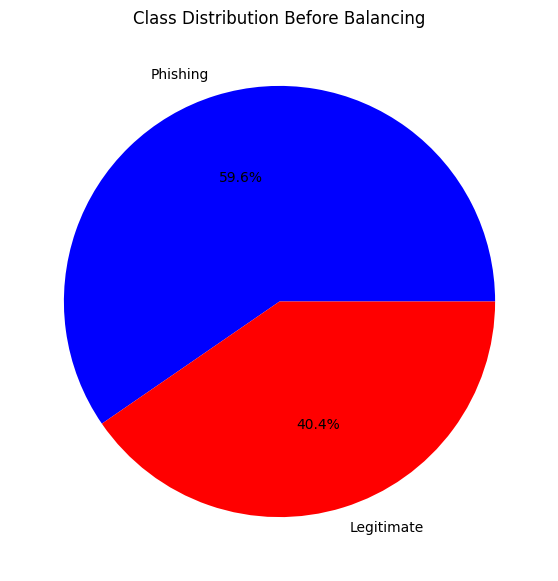

In [ ]:
plt.figure(figsize=(7, 7))
plt.pie(y_counts_original, labels=['Phishing', 'Legitimate'], autopct='%1.1f%%', colors=['blue', 'red'])
plt.title('Class Distribution Before Balancing')
plt.show()

In [ ]:
# Data Balancing using SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
print("Class distribution after SMOTE:", y_train_smote.value_counts())

Class distribution after SMOTE: status
1    391865
0    391865
Name: count, dtype: int64


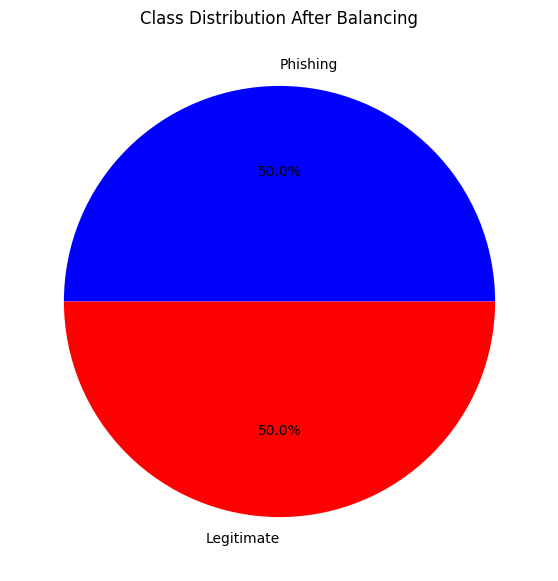

In [ ]:
y_counts_resampled = y_train_smote.value_counts()
plt.figure(figsize=(7, 7))
plt.pie(y_counts_resampled, labels=['Phishing', 'Legitimate'], autopct='%1.1f%%', colors=['blue', 'red'])
plt.title('Class Distribution After Balancing')
plt.show()

In [ ]:
# CatBoost model
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=42
)
model.fit(X_train_smote, y_train_smote)

0:	learn: 0.6252020	total: 295ms	remaining: 2m 27s
100:	learn: 0.3099697	total: 21.7s	remaining: 1m 25s
200:	learn: 0.2886600	total: 41.7s	remaining: 1m 2s
300:	learn: 0.2770701	total: 1m 2s	remaining: 41.6s
400:	learn: 0.2699416	total: 1m 22s	remaining: 20.5s
499:	learn: 0.2648277	total: 1m 43s	remaining: 0us


In [ ]:
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     66436
           1       0.90      0.93      0.92     97966

    accuracy                           0.90    164402
   macro avg       0.90      0.89      0.89    164402
weighted avg       0.90      0.90      0.90    164402

Accuracy: 0.90


In [ ]:
# XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_smote, y_train_smote)
y_pred = xgb_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:15:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     66436
           1       0.91      0.93      0.92     97966

    accuracy                           0.90    164402
   macro avg       0.90      0.90      0.90    164402
weighted avg       0.90      0.90      0.90    164402

Accuracy: 0.90


In [ ]:
import joblib
joblib.dump(xgb_model, 'XGBoost_model.pkl')

['XGBoost_model.pkl']

In [ ]:
# Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)
rf_model.fit(X_train_smote, y_train_smote)
y_pred = rf_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     66436
           1       0.93      0.93      0.93     97966

    accuracy                           0.91    164402
   macro avg       0.91      0.91      0.91    164402
weighted avg       0.91      0.91      0.91    164402

Accuracy: 0.91


In [ ]:
# Logistic Regression Classifier
lr_model = LogisticRegression(
    solver='liblinear',  # liblinear, saga
    random_state=42
)
lr_model.fit(X_train_smote, y_train_smote)
y_pred = lr_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75     66436
           1       0.84      0.81      0.83     97966

    accuracy                           0.80    164402
   macro avg       0.79      0.79      0.79    164402
weighted avg       0.80      0.80      0.80    164402

Accuracy: 0.80


In [ ]:
# Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_smote, y_train_smote)
y_pred = dt_classifier.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88     66436
           1       0.93      0.90      0.91     97966

    accuracy                           0.90    164402
   macro avg       0.89      0.90      0.89    164402
weighted avg       0.90      0.90      0.90    164402

Accuracy: 0.90


In [ ]:
# KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_smote, y_train_smote)
y_pred = knn_classifier.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86     66436
           1       0.92      0.89      0.90     97966

    accuracy                           0.89    164402
   macro avg       0.88      0.88      0.88    164402
weighted avg       0.89      0.89      0.89    164402

Accuracy: 0.89


In [ ]:
print("Training Accuracy:", model.score(X_train, y_train))
print("Testing Accuracy:", model.score(X_test, y_test))

Training Accuracy: 0.8977719249157553
Testing Accuracy: 0.8982372477220472


In [ ]:
# Comparing accuracy scores for each model
accuracies = [
    model.score(X_test, y_test),  # CatBoost
    xgb_model.score(X_test, y_test),  # XGBoost
    rf_model.score(X_test, y_test),  # Random Forest
    lr_model.score(X_test, y_test),  # Logistic Regression
    dt_classifier.score(X_test, y_test),  # Decision Tree
    knn_classifier.score(X_test, y_test)  # K-Nearest Neighbors
]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), accuracies, color=['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral', 'lightsteelblue'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Camparing Classification Report for each model
model_names = list(results.keys())

# Extracting the metrics for each model
precision_scores = [metrics['Precision'] for metrics in results.values()]
recall_scores = [metrics['Recall'] for metrics in results.values()]
f1_scores = [metrics['F1 Score'] for metrics in results.values()]

# Plotting the bar chart for all three metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision
axes[0].bar(model_names, precision_scores, color='skyblue')
axes[0].set_title("Precision Comparison")
axes[0].set_xlabel("Models")
axes[0].set_ylabel("Precision")
axes[0].set_ylim(0, 1)

# Recall
axes[1].bar(model_names, recall_scores, color='lightgreen')
axes[1].set_title("Recall Comparison")
axes[1].set_xlabel("Models")
axes[1].set_ylabel("Recall")
axes[1].set_ylim(0, 1)

# F1 Score
axes[2].bar(model_names, f1_scores, color='salmon')
axes[2].set_title("F1 Score Comparison")
axes[2].set_xlabel("Models")
axes[2].set_ylabel("F1 Score")
axes[2].set_ylim(0, 1)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

plt.plot(recall, precision, marker='.', label='CatBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, test_scores_mean, label='Validation Score')
plt.xlabel('Training Samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [ ]:
def main(url):
    status = []
    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))
    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))
    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))
    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    try:
        tld = get_tld(url, fail_silently=True)
        status.append(len(tld) if tld else -1)
    except:
        status.append(-1)
    status.append(tld_length(tld))

    return status

In [ ]:
def get_prediction_from_url(test_url):
    features_test = main(test_url)
    features_test = np.array(features_test).reshape((1, -1))
    pred = model.predict(features_test)
    if int(pred[0]) == 1:
        res = "Phishing"
    else:
        res = "Legitimate"

    return res

In [ ]:
urls = ['titaniumcorporate.co.za','www.amazon.com']
for url in urls:
     print(get_prediction_from_url(url))